# London Boroughs Battle

## Business Problem

Our customer BestIndSpice is a start-up company which main activity is import of Indian spices. They intend to open a brick and mortar shop in London and ask us to evaluate the London boroughs and identify the borough with highest potential for this business.
They target British Indian households from London that use to cook at home.


## Data and analytic approach

London is considered to be one of the world's most important global cities and has been called the world's most powerful, most desirable, most influential, most visited, most expensive,innovative,sustainable, most investment-friendly, and most-popular-for-work city” (https://en.wikipedia.org/wiki/London)

London population was about 8.2 millions according to latest census from 2011.  
Around 6.6% of London's population is of Indian origin,  largest ethnic minority group (more than 540 thousands in 2011).

From administrative perspective, London has 32 boroughs. 

To identified the boroughs with the highest potential for Indian spices business we are going to use cluster analysis (k-means) on the  following dimensions considered with impact:

- number of British Indians living in London and the share in total population (source:https://data.london.gov.uk/dataset/ethnic-group-population-projections) 
- number of Indian restaurants (source: Fousquare API)
- number  of specialized spices stores (source: Fousquare API)


## Data Collection and Processing

In [ ]:
!conda install -c conda-forge geopy --yes

In [ ]:
!conda install -c conda-forge folium=0.5.0 --yes 

In [4]:
import pandas as pd
# Import libraries
import numpy as np # library to handle data in a vectorized manner
import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium # map rendering library

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

In [40]:
# list of london borough and their coordinates
!wget --quiet https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DP0701EN/labs/Data_Files/london_coordinates.xlsx
df_london_borough = pd.read_excel('london_coordinates.xlsx')
df_london_borough.rename(columns={'Borough':'borough'}, inplace=True)
df_london_borough=df_london_borough[df_london_borough['borough']!='City of London'] # City of London is not considered borough
df_london_borough.head()

,borough,longitude,latitude
0,Barking and Dagenham,0.1557,51.5607
1,Barnet,-0.1517,51.6252
2,Bexley,0.1505,51.4549
3,Brent,-0.2817,51.5588
4,Bromley,0.0198,51.4039


In [10]:
# population data forecast
# population forecast file is around 38MB. it might take a while to download

!wget --quiet https://data.london.gov.uk/download/ethnic-group-population-projections/a9598ef0-808c-4f96-9eac-8bb314bd92cd/Ethnic%20group%20projections%20%282016-based%20central%20trend%29.xlsx
df_population = pd.read_excel('Ethnic group projections (2016-based central trend).xlsx', sheet_name= 'Population - Persons')
df_population.head()



,gss_code,borough,sex,age,ethnic_group,2011,2012,2013,2014,2015,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
0,E09000001,City of London,Persons,0,All persons,69,72,67,66,63,...,61,61,62,62,62,62,62,62,62,62
1,E09000001,City of London,Persons,1,All persons,52,69,63,65,65,...,54,54,55,55,55,55,55,55,55,55
2,E09000001,City of London,Persons,2,All persons,37,56,69,71,78,...,49,49,49,49,50,50,50,50,50,50
3,E09000001,City of London,Persons,3,All persons,41,45,55,75,79,...,50,50,50,50,51,51,51,51,51,51
4,E09000001,City of London,Persons,4,All persons,34,42,42,55,83,...,51,51,51,51,51,51,51,52,52,52


In [46]:
df_Indian_pop=df_population[['borough',2025]][(df_population['age']=='All ages') & 
                                (df_population['ethnic_group']=='Indian')].reset_index(drop = True)
print(df_Indian_pop.shape)
df_Indian_pop.rename(columns={2025 : 'Indian_pop_fcast_2025'}  , inplace = True)
df_Indian_pop.head(2)


(36, 2)


,borough,Indian_pop_fcast_2025
0,City of London,261
1,Barking and Dagenham,15102


In [47]:

df_all_pop=df_population[['borough', 2025]][(df_population['age']=='All ages') & 
                                (df_population['ethnic_group']=='All persons')].reset_index(drop = True)
print(df_all_pop.shape)
df_all_pop.rename(columns={2025 : 'London_all_pop_fcast_2025'}  , inplace = True)
df_all_pop.head(2)


(36, 2)


,borough,London_all_pop_fcast_2025
0,City of London,7556
1,Barking and Dagenham,237099


In [14]:
#income by borough
!wget --quiet https://data.london.gov.uk/download/earnings-place-residence-borough/1686ef1c-b169-442d-8877-e7e49788f668/earnings-residence-borough.xlsx
df_earnings =pd.read_excel("earnings-residence-borough.xlsx", sheet_name = "Total, weekly", 
                           skiprows=range(4),
                           usecols = (1,36),
                           header=None,
                           nrows=32) 
df_earnings.columns=['borough','Weekly_earning_2109']
print(df_earnings.shape)
df_earnings.head()

(32, 2)


,borough,Weekly_earning_2109
0,Barking and Dagenham,472.9
1,Barnet,536.6
2,Bexley,550.2
3,Brent,524.6
4,Bromley,641.3


### Data about venues from Foursquare API

In [16]:

CLIENT_ID = 'MY KEY' 
CLIENT_SECRET = 'MY KEY' 

In [17]:
# these helper functions help handling error due to missing key in dictionary

def checkKey(dict, key):
    if key in dict:
        return dict[key]
    else: 
        return "-NA-"

def checkCategories (list, key):
    if len(list)>0 :
        dict=list[0]
        return checkKey(dict,key)
    else:
        return "-NA-"


For our analysis we need info about Indian restaurants and Herbs & Spices Stores. We defined getNearbyVenuesByCategId function to extract info from Foursquare API filtering by CategoryId.

Using https://developer.foursquare.com/docs/build-with-foursquare/categories/ we found that 
Indian Restaurant has CategoryId 4bf58dd8d48988d10f941735
Herbs & Spices Store has CategoryId 52f2ab2ebcbc57f1066b8b2c



In [18]:

def getNearbyVenuesByCategId(names, latitudes, longitudes, radius, VERSION, LIMIT, categoryId, intent):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&intent={}&radius={}&limit={}'.format(
                CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, categoryId, intent, radius, LIMIT)
        # print(url)   
        # make the GET request
        # print(requests.get(url).json())
        results = requests.get(url).json()['response']['venues']

        # return only relevant information for each venue
            
        a = [(name, 
            lat, 
            lng, 
            v['id'],
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],
            v['location']['distance'],
            checkKey(v['location'],'city'),
            v['location']['country'],
            checkCategories(v['categories'],'name'),
            checkCategories(v['categories'],'shortName'),
            checkCategories(v['categories'],'id'))
            for v in results]
        # print(a)
        venues_list.append(a)    

    
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['borough', 
                  'Borough Latitude', 
                  'Borough Longitude',
                  'Venue Id',
                  'Venue Name', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Distance',
                  'Venue City', 
                  'Venue Country',
                  'Venue Category',
                  'Venue Short Category',
                  'CategId']
    
    #retain only record with primary Categ ID = categoryId
    nearby_venues = nearby_venues[nearby_venues['CategId']==categoryId]
    
    return(nearby_venues)

In [19]:
#extract indian restaurant searching by category Id  https://developer.foursquare.com/docs/build-with-foursquare/categories/

df_london_indian_rest = getNearbyVenuesByCategId(names =df_london_borough['borough'], 
                                          latitudes=df_london_borough['latitude'], 
                                          longitudes=df_london_borough['longitude'], 
                                          VERSION='20200331', 
                                          radius =1500,
                                          LIMIT=100, 
                                         categoryId='4bf58dd8d48988d10f941735', intent='browse')


In [20]:
print(df_london_indian_rest.shape)
df_london_indian_rest.head() 

(701, 13)


,borough,Borough Latitude,Borough Longitude,Venue Id,Venue Name,Venue Latitude,Venue Longitude,Venue Distance,Venue City,Venue Country,Venue Category,Venue Short Category,CategId
0,Barking and Dagenham,51.5607,0.1557,4f3561afe4b0debe1f187692,Saffron Restaurant,51.565345,0.171533,1211,-NA-,United Kingdom,Indian Restaurant,Indian,4bf58dd8d48988d10f941735
1,Barking and Dagenham,51.5607,0.1557,52cdc68311d23a96916b2892,Tarka,51.552033,0.162370,1069,Dagenham,United Kingdom,Indian Restaurant,Indian,4bf58dd8d48988d10f941735
2,Barking and Dagenham,51.5607,0.1557,4bfd89eff7c82d7f4b558e04,Shirins Tandoori,51.572158,0.166567,1480,London,United Kingdom,Indian Restaurant,Indian,4bf58dd8d48988d10f941735
3,Barking and Dagenham,51.5607,0.1557,5638ff6060b2753ece75b57a,Clay Oven Indian Takeaway,51.563209,0.146845,673,-NA-,United Kingdom,Indian Restaurant,Indian,4bf58dd8d48988d10f941735
4,Barnet,51.6252,-0.1517,4b4cebf1f964a5204bc426e3,Boulevard Club,51.614627,-0.149623,1185,London,United Kingdom,Indian Restaurant,Indian,4bf58dd8d48988d10f941735


In [41]:
df_rest_by_borough = df_london_indian_rest.groupby('borough',as_index=False).count()[['borough', 'Venue Id']]
df_rest_by_borough.columns = ['borough', 'Number_of_Indian_restaurants']
df_rest_by_borough.head()

,borough,Number_of_Indian_restaurants
0,Barking and Dagenham,4
1,Barnet,7
2,Bexley,8
3,Brent,28
4,Bromley,15


In [23]:
df_london_spices_ID = getNearbyVenuesByCategId(names =df_london_borough['borough'], 
                                          latitudes=df_london_borough['latitude'], 
                                          longitudes=df_london_borough['longitude'], 
                                          radius =3000, 
                                          VERSION='20200331', 
                                          LIMIT=100, 
                                          categoryId='52f2ab2ebcbc57f1066b8b2c', intent='browse')
df_london_spices_ID.to_csv('df_london_spices_ID.csv')
print(df_london_spices_ID.shape)

(12, 13)


In [ ]:
df_london_spices_ID.sort_values(by = ['Venue Id', 'Venue Distance'], inplace = True)
df_closest_london_spices= df_london_spices_ID.groupby('Venue Id').head(1).reset_index(drop=True)
df_closest_london_spices

In [29]:
df_spices_store_by_borough = df_closest_london_spices.groupby('borough',as_index=False).count()[['borough', 'Venue Id']]
type(df_spices_store_by_borough)
df_spices_store_by_borough.columns=['borough', 'Number_of_spices_stores']
df_spices_store_by_borough

,borough,Number_of_spices_stores
0,Brent,1
1,City of London,1
2,Hammersmith and Fulham,1
3,Kensington and Chelsea,1
4,Richmond upon Thames,2
5,Southwark,2


### Data centralization and processing

In [50]:
#centralize all info in one dataframe

from functools import reduce
df_all_sets = [df_london_borough,  df_Indian_pop, df_all_pop, df_rest_by_borough ,df_spices_store_by_borough]

df_London_Cum_Info = reduce(lambda left,right: pd.merge(left,right,on=['borough'],
                                            how='left'), df_all_sets)
print(df_London_Cum_Info.shape)

df_London_Cum_Info.head()


(32, 7)


,borough,longitude,latitude,Indian_pop_fcast_2025,London_all_pop_fcast_2025,Number_of_Indian_restaurants,Number_of_spices_stores
0,Barking and Dagenham,0.1557,51.5607,15102,237099,4,NaN
1,Barnet,-0.1517,51.6252,32852,429365,7,NaN
2,Bexley,0.1505,51.4549,9763,265504,8,NaN
3,Brent,-0.2817,51.5588,64047,358014,28,1.0
4,Bromley,0.0198,51.4039,9620,358360,15,NaN


In [51]:
# create two new features, replace NaN with 0
df_London_Cum_Info['Share_of_Indian_pop_in_total'] = df_London_Cum_Info['Indian_pop_fcast_2025']/df_London_Cum_Info['London_all_pop_fcast_2025']
df_London_Cum_Info['Number_of_Indian_rest_for10tho'] = df_London_Cum_Info['Number_of_Indian_restaurants']*10000/df_London_Cum_Info['Indian_pop_fcast_2025']
df_London_Cum_Info['Number_of_spices_stores'].fillna(value = 0, inplace=True)
df_London_Cum_Info = df_London_Cum_Info.astype({'Number_of_spices_stores' :'int64'}, copy=False)
df_London_Cum_Info.head()

,borough,longitude,latitude,Indian_pop_fcast_2025,London_all_pop_fcast_2025,Number_of_Indian_restaurants,Number_of_spices_stores,Share_of_Indian_pop_in_total,Number_of_Indian_rest_for10tho
0,Barking and Dagenham,0.1557,51.5607,15102,237099,4,0,0.063695,2.648656
1,Barnet,-0.1517,51.6252,32852,429365,7,0,0.076513,2.130768
2,Bexley,0.1505,51.4549,9763,265504,8,0,0.036772,8.194203
3,Brent,-0.2817,51.5588,64047,358014,28,1,0.178895,4.371789
4,Bromley,0.0198,51.4039,9620,358360,15,0,0.026845,15.592516


## Boroughs Clustering

In [53]:
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import silhouette_score
%matplotlib inline

In [52]:
X= df_London_Cum_Info[['Indian_pop_fcast_2025', 'Share_of_Indian_pop_in_total', 'Number_of_Indian_rest_for10tho']]
print(X.shape)


(32, 3)


In [71]:

X_std = preprocessing.StandardScaler().fit(X).transform(X.astype(float))



# estimate optimal kclusters using silhouette_score

kmax = 10
# sil_score=[]
sil_score = np.zeros((kmax-1))
print(sil_score)

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1) :
  k_means = KMeans(init = "k-means++", n_clusters=k, random_state=0,  n_init = 30).fit(X_std)
  labels = k_means.labels_
  #sil_score.append(silhouette_score(X_std, labels, metric = 'euclidean'))
  sil_score[k-2] = silhouette_score(X_std, labels, metric = 'euclidean')

print(sil_score)

kclusters=sil_score.argmax()+2
k_means = KMeans(init = "k-means++", n_clusters=kclusters, random_state=0,  n_init = 30).fit(X_std)
labels = k_means.labels_

try:
    df_London_Cum_Info = df_London_Cum_Info.drop('Cluster Labels', axis=1)
except:
    print('Cluster Labels does not exist in df_London_Cum_Info.')   
    
df_London_Cum_Info.insert(0, 'Cluster Labels', k_means.labels_)


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


[0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.66873288 0.69492479 0.53685057 0.51690057 0.57013145 0.55458069
 0.53485611 0.5003478  0.39829489]
Cluster Labels does not exist in df_London_Cum_Info.


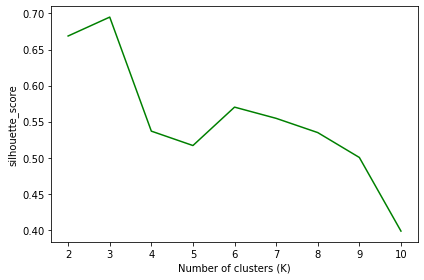

In [72]:
plt.plot(range(2,kmax+1),sil_score,'g')
plt.ylabel('silhouette_score')
plt.xlabel('Number of clusters (K)')
plt.tight_layout()
plt.show()

In [73]:
print( "The max silhouette_score was ", sil_score.max(), "with k=", sil_score.argmax()+2) 

The max silhouette_score was  0.6949247896996393 with k= 3


In [74]:
# explorare profil segmente
df_London_Cum_Info['Cluster Labels'].value_counts()

0    23
1     7
2     2
Name: Cluster Labels, dtype: int64

In [75]:
df_London_Cum_Info.groupby(['Cluster Labels']).mean()

,longitude,latitude,Indian_pop_fcast_2025,London_all_pop_fcast_2025,Number_of_Indian_restaurants,Number_of_spices_stores,Share_of_Indian_pop_in_total,Number_of_Indian_rest_for10tho
Cluster Labels,,,,,,,,
0,-0.075543,51.497374,11354.260870,301419.304348,18.434783,0.173913,0.037045,20.957077
1,-0.235457,51.535286,64551.857143,336386.571429,22.714286,0.142857,0.196802,3.568915
2,-0.214300,51.497350,3030.000000,177885.500000,36.500000,1.000000,0.016963,124.106050


In [76]:
# Retrieve the Latitude and Longitude for London

geolocator = Nominatim(user_agent="London_explorer")

location = geolocator.geocode("London, UK")
latitude = location.latitude
longitude = location.longitude

print('London, UK latitude and longitude are {}, {}.'.format(latitude, longitude))

London, UK latitude and longitude are 51.5073219, -0.1276474.


In [84]:

london_map = folium.Map(location=[latitude, longitude], zoom_start=10)


# add markers to map
for lat, lng, label in zip(df_london_borough['latitude'], df_london_borough['longitude'], df_london_borough['borough']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=20,
        popup=label,
        color='darkblue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.2,
        parse_html=False).add_to(london_map)  
    
london_map

In [86]:

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_London_Cum_Info['latitude'], df_London_Cum_Info['longitude'], 
                                  df_London_Cum_Info['borough'], df_London_Cum_Info['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=15,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.3).add_to(map_clusters)
       
map_clusters

![](https://github.com/AMJ234/Coursera_Capstone/blob/master/Clusters_map.PNG?raw=true "Clusters on London map")


In [83]:
df_London_Cum_Info[df_London_Cum_Info['Cluster Labels']==1]

,Cluster Labels,borough,longitude,latitude,Indian_pop_fcast_2025,London_all_pop_fcast_2025,Number_of_Indian_restaurants,Number_of_spices_stores,Share_of_Indian_pop_in_total,Number_of_Indian_rest_for10tho
3,1,Brent,-0.2817,51.5588,64047,358014,28,1,0.178895,4.371789
7,1,Ealing,-0.3089,51.5130,51134,371105,32,0,0.137788,6.258067
13,1,Harrow,-0.3346,51.5898,83056,272524,28,0,0.304766,3.371219
15,1,Hillingdon,-0.4760,51.5441,60196,335476,6,0,0.179435,0.996744
16,1,Hounslow,-0.3680,51.4746,64483,298722,42,0,0.215863,6.513345
23,1,Newham,0.0469,51.5077,62283,381525,2,0,0.163247,0.321115
24,1,Redbridge,0.0741,51.5590,66664,337340,21,0,0.197617,3.150126
